## hitmap을 이용한 corr 시각화(age 위주)

In [2]:
import re
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, Dataset
import seaborn as sns
import matplotlib.pyplot as plt

In [40]:
users = pd.read_csv('../data/' + 'users.csv')
books = pd.read_csv('../data/' + 'books.csv')
train = pd.read_csv('../data/' + 'train_ratings.csv')
test = pd.read_csv('../data/' + 'test_ratings.csv')
sub = pd.read_csv('../data/' + 'sample_submission.csv')

In [41]:
users = users.dropna(subset=['age'])

In [48]:
def make_category_high(books:pd.DataFrame) -> pd.DataFrame:
    books.loc[books[books['category'].notnull()].index, 'category'] = books[books['category'].notnull()]['category'].apply(lambda x: re.sub('[\W_]+',' ',x).strip())
    books['category'] = books['category'].str.lower()
    categories = ['garden','crafts','physics','adventure','music','fiction','nonfiction','science','science fiction','social','homicide',
    'sociology','disease','religion','christian','philosophy','psycholog','mathemat','agricult','environmental',
    'business','poetry','drama','literary','travel','motion picture','children','cook','literature','electronic',
    'humor','animal','bird','photograph','computer','house','ecology','family','architect','camp','criminal','language','india']

    books['category_high'] = books['category'].copy()
    for category in categories:
        books.loc[books[books['category'].str.contains(category,na=False)].index,'category_high'] = category
        
    category_high_df = pd.DataFrame(books['category_high'].value_counts()).reset_index()
    category_high_df.columns = ['category','count']
    others_list = category_high_df[category_high_df['count']<5]['category'].values
    books.loc[books[books['category_high'].isin(others_list)].index, 'category_high']='others'
    return books
books = make_category_high(books)

In [49]:
test_df = train.merge(users, how="left", on='user_id')
test_df = test_df.merge(books, how="left", on='isbn')

In [50]:
def age_map(x: int) -> int:
    x = int(x)
    if x < 20:
        return 1
    elif x >= 20 and x < 30:
        return 2
    elif x >= 30 and x < 40:
        return 3
    elif x >= 40 and x < 50:
        return 4
    elif x >= 50 and x < 60:
        return 5
    else:
        return 6

In [51]:
test_df

,user_id,isbn,rating,location,age,book_title,book_author,year_of_publication,publisher,img_url,language,category,summary,img_path,category_high
0,8,0002005018,4,NaN,NaN,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,en,actresses,"In a small town in Canada, Clara Callan reluct...",images/0002005018.01.THUMBZZZ.jpg,actresses
1,67544,0002005018,7,"toronto, ontario, canada",30.0,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,en,actresses,"In a small town in Canada, Clara Callan reluct...",images/0002005018.01.THUMBZZZ.jpg,actresses
2,123629,0002005018,8,NaN,NaN,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,en,actresses,"In a small town in Canada, Clara Callan reluct...",images/0002005018.01.THUMBZZZ.jpg,actresses
3,200273,0002005018,8,NaN,NaN,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,en,actresses,"In a small town in Canada, Clara Callan reluct...",images/0002005018.01.THUMBZZZ.jpg,actresses
4,210926,0002005018,9,NaN,NaN,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,en,actresses,"In a small town in Canada, Clara Callan reluct...",images/0002005018.01.THUMBZZZ.jpg,actresses
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
306790,278843,0743525493,7,"pismo beach, california, usa",28.0,The Motley Fool's What To Do with Your Money N...,David Gardner,2002.0,Simon & Schuster Audio,http://images.amazon.com/images/P/0743525493.0...,NaN,NaN,NaN,images/0743525493.01.THUMBZZZ.jpg,NaN
306791,278851,067161746X,6,"dallas, texas, usa",33.0,The Bachelor Home Companion: A Practical Guide...,P.J. O'Rourke,1987.0,Pocket Books,http://images.amazon.com/images/P/067161746X.0...,en,humor,A tongue-in-cheek survival guide for single pe...,images/067161746X.01.THUMBZZZ.jpg,humor
306792,278851,0884159221,7,"dallas, texas, usa",33.0,Why stop?: A guide to Texas historical roadsid...,Claude Dooley,1985.0,Lone Star Books,http://images.amazon.com/images/P/0884159221.0...,NaN,NaN,NaN,images/0884159221.01.THUMBZZZ.jpg,NaN
306793,278851,0912333022,7,"dallas, texas, usa",33.0,The Are You Being Served? Stories: 'Camping In...,Jeremy Lloyd,1997.0,Kqed Books,http://images.amazon.com/images/P/0912333022.0...,en,fiction,These hilarious stories by the creator of publ...,images/0912333022.01.THUMBZZZ.jpg,fiction


In [54]:
test_df['location'] = test_df['location'].fillna(",,").astype(str)

In [55]:
test_df['location_city'] = test_df['location'].apply(lambda x: x.split(',')[0])
test_df['location_state'] = test_df['location'].apply(lambda x: x.split(',')[1])
test_df['location_country'] = test_df['location'].apply(lambda x: x.split(',')[2])
test_df = test_df.drop(['location'], axis=1)

In [56]:
test_df['book_author'] = test_df['book_author'].str.replace('.','', regex=True)
test_df['book_author'] = test_df['book_author'].str.replace('_',' ', regex=True)
test_df['book_author'] = test_df['book_author'].str.lower()
test_df['book_author'] = test_df['book_author'].apply(lambda x:' '.join(sorted(x.split())))

In [57]:
loc_city2idx = {v:k for k,v in enumerate(test_df['location_city'].unique())}
loc_state2idx = {v:k for k,v in enumerate(test_df['location_state'].unique())}
loc_country2idx = {v:k for k,v in enumerate(test_df['location_country'].unique())}
category2idx = {v:k for k,v in enumerate(test_df['category'].unique())}
categoryhigh2idx = {v:k for k,v in enumerate(test_df['category_high'].unique())}
publisher2idx = {v:k for k,v in enumerate(test_df['publisher'].unique())}
language2idx = {v:k for k,v in enumerate(test_df['language'].unique())}
author2idx = {v:k for k,v in enumerate(test_df['book_author'].unique())}

In [58]:
test_df['location_city'] = test_df['location_city'].map(loc_city2idx)
test_df['location_state'] = test_df['location_state'].map(loc_state2idx)
test_df['location_country'] = test_df['location_country'].map(loc_country2idx)
test_df['age'] = test_df['age'].fillna(int(test_df['age'].mean()))
test_df['age'] = test_df['age'].apply(age_map)
test_df['category'] = test_df['category'].map(category2idx)
test_df['category_high'] = test_df['category_high'].map(categoryhigh2idx)
test_df['publisher'] = test_df['publisher'].map(publisher2idx)
test_df['language'] = test_df['language'].map(language2idx)
test_df['book_author'] = test_df['book_author'].map(author2idx)

In [62]:
test_df

,user_id,isbn,rating,age,book_title,book_author,year_of_publication,publisher,img_url,language,category,summary,img_path,category_high,location_city,location_state,location_country
0,8,0002005018,4,3,Clara Callan,0,2001.0,0,http://images.amazon.com/images/P/0002005018.0...,0,0,"In a small town in Canada, Clara Callan reluct...",images/0002005018.01.THUMBZZZ.jpg,0,0,0,0
1,67544,0002005018,7,3,Clara Callan,0,2001.0,0,http://images.amazon.com/images/P/0002005018.0...,0,0,"In a small town in Canada, Clara Callan reluct...",images/0002005018.01.THUMBZZZ.jpg,0,1,1,1
2,123629,0002005018,8,3,Clara Callan,0,2001.0,0,http://images.amazon.com/images/P/0002005018.0...,0,0,"In a small town in Canada, Clara Callan reluct...",images/0002005018.01.THUMBZZZ.jpg,0,0,0,0
3,200273,0002005018,8,3,Clara Callan,0,2001.0,0,http://images.amazon.com/images/P/0002005018.0...,0,0,"In a small town in Canada, Clara Callan reluct...",images/0002005018.01.THUMBZZZ.jpg,0,0,0,0
4,210926,0002005018,9,3,Clara Callan,0,2001.0,0,http://images.amazon.com/images/P/0002005018.0...,0,0,"In a small town in Canada, Clara Callan reluct...",images/0002005018.01.THUMBZZZ.jpg,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
306790,278843,0743525493,7,2,The Motley Fool's What To Do with Your Money N...,1215,2002.0,2171,http://images.amazon.com/images/P/0743525493.0...,1,5,NaN,images/0743525493.01.THUMBZZZ.jpg,5,1246,6,2
306791,278851,067161746X,6,3,The Bachelor Home Companion: A Practical Guide...,67,1987.0,222,http://images.amazon.com/images/P/067161746X.0...,0,7,A tongue-in-cheek survival guide for single pe...,images/067161746X.01.THUMBZZZ.jpg,7,340,9,2
306792,278851,0884159221,7,3,Why stop?: A guide to Texas historical roadsid...,52403,1985.0,10406,http://images.amazon.com/images/P/0884159221.0...,1,5,NaN,images/0884159221.01.THUMBZZZ.jpg,5,340,9,2
306793,278851,0912333022,7,3,The Are You Being Served? Stories: 'Camping In...,52404,1997.0,6387,http://images.amazon.com/images/P/0912333022.0...,0,3,These hilarious stories by the creator of publ...,images/0912333022.01.THUMBZZZ.jpg,3,340,9,2


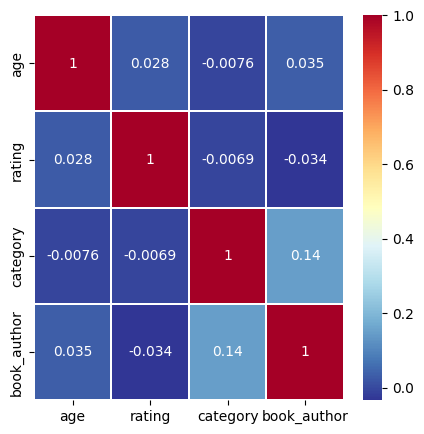

In [64]:
plt.figure(figsize = (5, 5))
sns.heatmap(test_df[['age','rating','category', 'book_author']].corr(), linewidths=0.1, vmax=1, cmap='RdYlBu_r', linecolor='white',annot=True)
plt.show()